In [6]:
import torch
import xarray as xr
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import time
from torch.utils.data import DataLoader, TensorDataset
import dask
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR


In [2]:
print("Versión de PyTorch:", torch.__version__)
print("Versión de CUDA usada por PyTorch:", torch.version.cuda)


Versión de PyTorch: 2.5.1
Versión de CUDA usada por PyTorch: 12.1


In [3]:
# Intentar abrir el archivo
dataset_path = 'gs://weatherbench2/datasets/era5/1959-2022-6h-1440x721.zarr'
ds = xr.open_zarr(dataset_path)

# Ver la información del dataset
print(ds)

<xarray.Dataset> Size: 41TB
Dimensions:                                           (time: 92044,
                                                       latitude: 721,
                                                       longitude: 1440,
                                                       level: 13)
Coordinates:
  * latitude                                          (latitude) float32 3kB ...
  * level                                             (level) int64 104B 50 ....
  * longitude                                         (longitude) float32 6kB ...
  * time                                              (time) datetime64[ns] 736kB ...
Data variables: (12/38)
    10m_u_component_of_wind                           (time, latitude, longitude) float32 382GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    10m_v_component_of_wind                           (time, latitude, longitude) float32 382GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    10m_wind_speed           

In [4]:
# Verificar los límites de las coordenadas en el dataset
lat_min = ds['latitude'].min().values
lat_max = ds['latitude'].max().values
lon_min = ds['longitude'].min().values
lon_max = ds['longitude'].max().values

print(f"Rango de latitud en el dataset: {lat_min} a {lat_max}")
print(f"Rango de longitud en el dataset: {lon_min} a {lon_max}")

Rango de latitud en el dataset: -90.0 a 90.0
Rango de longitud en el dataset: 0.0 a 359.75


In [5]:
print("Dimensiones del dataset:", ds.dims)

Dimensiones del dataset: FrozenMappingWarningOnValuesAccess({'time': 92044, 'latitude': 721, 'longitude': 1440, 'level': 13})


In [6]:
subset = ds.isel(latitude=slice(0, 50), longitude=slice(0, 50), time=slice(0, 5))
print(subset)

<xarray.Dataset> Size: 6MB
Dimensions:                                           (time: 5, latitude: 50,
                                                       longitude: 50, level: 13)
Coordinates:
  * latitude                                          (latitude) float32 200B ...
  * level                                             (level) int64 104B 50 ....
  * longitude                                         (longitude) float32 200B ...
  * time                                              (time) datetime64[ns] 40B ...
Data variables: (12/38)
    10m_u_component_of_wind                           (time, latitude, longitude) float32 50kB dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    10m_v_component_of_wind                           (time, latitude, longitude) float32 50kB dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    10m_wind_speed                                    (time, latitude, longitude) float32 50kB dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    2m_te

In [7]:
# Seleccionar datos de Chile (latitudes y longitudes del cono sur)
chile_ds = ds.sel(
    latitude=slice(-17.0, -56.0),  # Latitudes desde el norte de Chile hasta Tierra del Fuego
    longitude=slice(280.0, 310.0)  # Longitudes convertidas de -80° a -50°
)

# Verificar el subset
print(chile_ds)

<xarray.Dataset> Size: 755GB
Dimensions:                                           (time: 92044,
                                                       latitude: 157,
                                                       longitude: 121, level: 13)
Coordinates:
  * latitude                                          (latitude) float32 628B ...
  * level                                             (level) int64 104B 50 ....
  * longitude                                         (longitude) float32 484B ...
  * time                                              (time) datetime64[ns] 736kB ...
Data variables: (12/38)
    10m_u_component_of_wind                           (time, latitude, longitude) float32 7GB dask.array<chunksize=(1, 157, 121), meta=np.ndarray>
    10m_v_component_of_wind                           (time, latitude, longitude) float32 7GB dask.array<chunksize=(1, 157, 121), meta=np.ndarray>
    10m_wind_speed                                    (time, latitude, longitude) float3

In [8]:
# Verificar los límites del subset
lat_min = chile_ds['latitude'].min().values
lat_max = chile_ds['latitude'].max().values
lon_min = chile_ds['longitude'].min().values
lon_max = chile_ds['longitude'].max().values

print(f"Rango de latitud seleccionado: {lat_min} a {lat_max}")
print(f"Rango de longitud seleccionado: {lon_min} a {lon_max}")

Rango de latitud seleccionado: -56.0 a -17.0
Rango de longitud seleccionado: 280.0 a 310.0


In [9]:
for var in chile_ds.data_vars:
    print(f"{var}: {chile_ds[var].shape}")

10m_u_component_of_wind: (92044, 157, 121)
10m_v_component_of_wind: (92044, 157, 121)
10m_wind_speed: (92044, 157, 121)
2m_temperature: (92044, 157, 121)
angle_of_sub_gridscale_orography: (157, 121)
anisotropy_of_sub_gridscale_orography: (157, 121)
geopotential: (92044, 13, 157, 121)
geopotential_at_surface: (157, 121)
high_vegetation_cover: (157, 121)
lake_cover: (157, 121)
lake_depth: (157, 121)
land_sea_mask: (157, 121)
low_vegetation_cover: (157, 121)
mean_sea_level_pressure: (92044, 157, 121)
sea_ice_cover: (92044, 157, 121)
sea_surface_temperature: (92044, 157, 121)
slope_of_sub_gridscale_orography: (157, 121)
soil_type: (157, 121)
specific_humidity: (92044, 13, 157, 121)
standard_deviation_of_filtered_subgrid_orography: (157, 121)
standard_deviation_of_orography: (157, 121)
surface_pressure: (92044, 157, 121)
temperature: (92044, 13, 157, 121)
toa_incident_solar_radiation: (92044, 157, 121)
toa_incident_solar_radiation_12hr: (92044, 157, 121)
toa_incident_solar_radiation_24hr: (

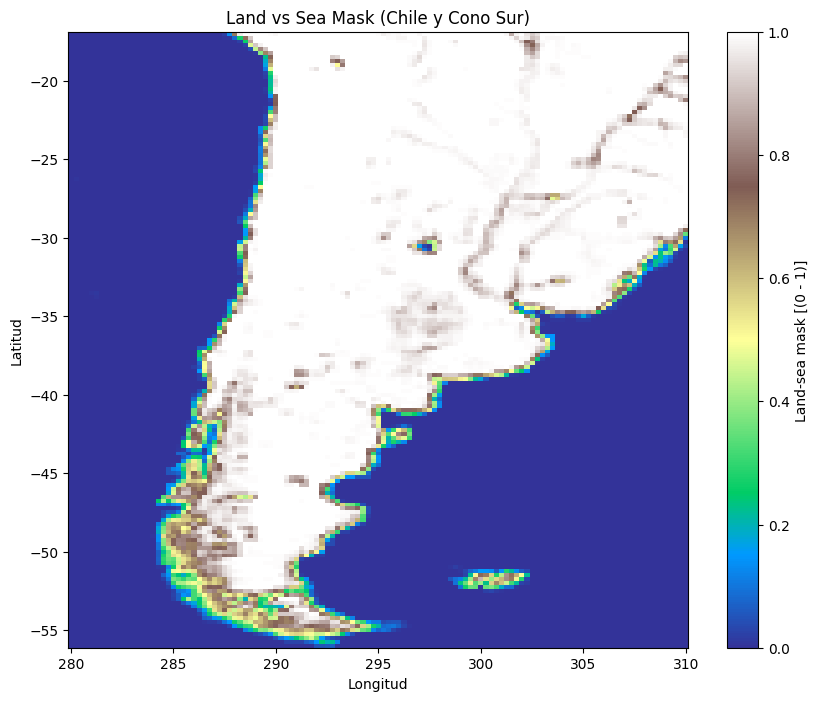

In [10]:
land_sea = chile_ds['land_sea_mask']
plt.figure(figsize=(10, 8))
land_sea.plot(cmap="terrain", add_colorbar=True)
plt.title("Land vs Sea Mask (Chile y Cono Sur)")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()

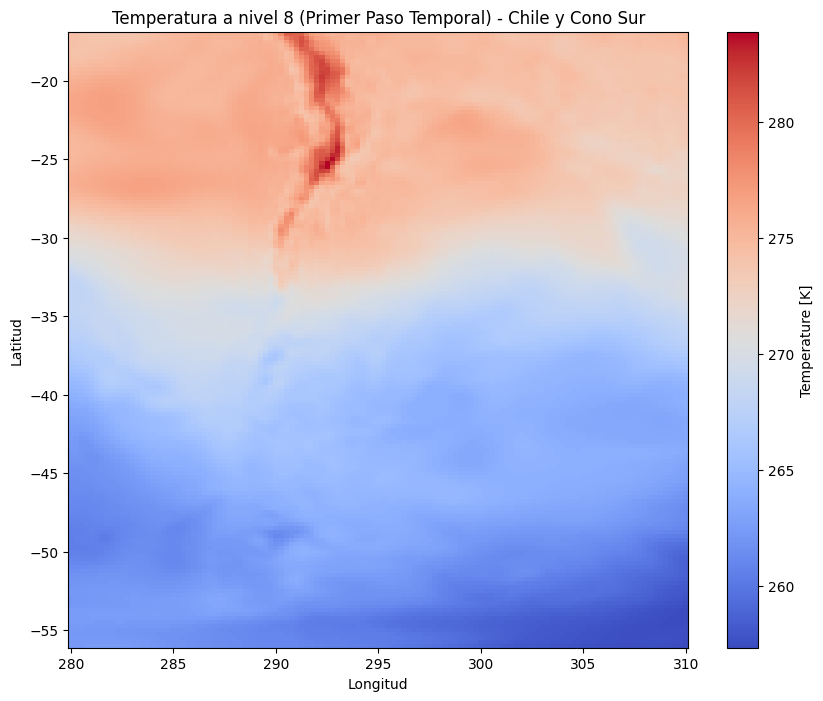

In [11]:
temperature = chile_ds['temperature'].isel(time=0, level=8)
plt.figure(figsize=(10, 8))
temperature.plot(cmap="coolwarm", add_colorbar=True)
plt.title("Temperatura a nivel 8 (Primer Paso Temporal) - Chile y Cono Sur")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()

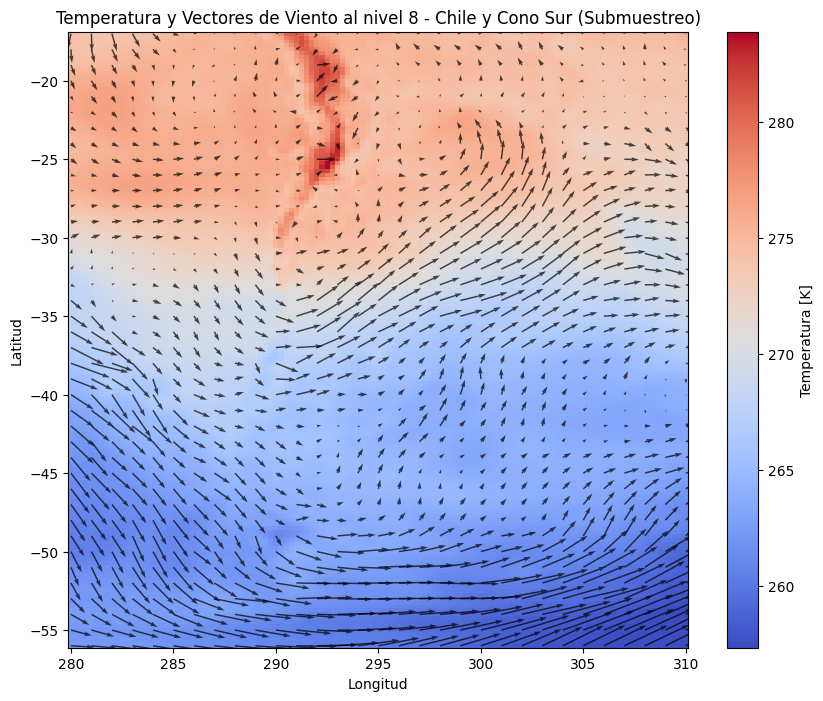

In [99]:
temp_2m = chile_ds['temperature'].isel(time=0, level=8)
u_wind = chile_ds['u_component_of_wind'].isel(time=0, level=8)
v_wind = chile_ds['v_component_of_wind'].isel(time=0, level=8)

lon, lat = np.meshgrid(chile_ds['longitude'], chile_ds['latitude'])

step = 4
lon_subset = lon[::step, ::step]
lat_subset = lat[::step, ::step]
u_wind_subset = u_wind[::step, ::step]
v_wind_subset = v_wind[::step, ::step]

plt.figure(figsize=(10, 8))

plt.pcolormesh(lon, lat, temp_2m, cmap="coolwarm", shading="auto")
plt.colorbar(label="Temperatura [K]")
plt.quiver(lon_subset, lat_subset, u_wind_subset, v_wind_subset, scale=300, color='black', alpha=0.7)
plt.title("Temperatura y Vectores de Viento al nivel 8 - Chile y Cono Sur (Submuestreo)")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()

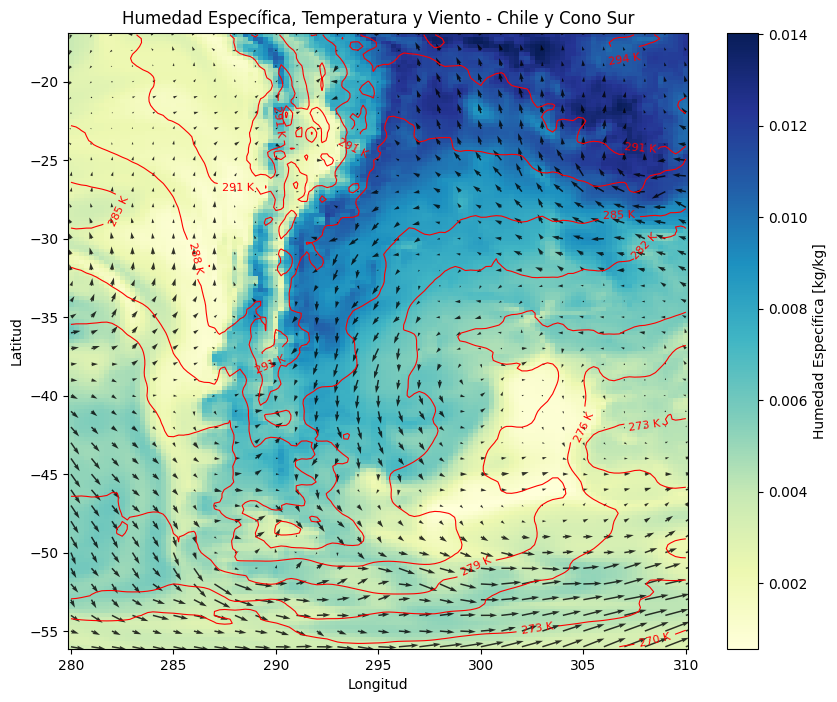

In [101]:
temperature = chile_ds['temperature'].isel(time=0, level=10)
specific_humidity = chile_ds['specific_humidity'].isel(time=0, level=10)  # Humedad específica en el mismo nivel
u_wind = chile_ds['u_component_of_wind'].isel(time=0, level=10)
v_wind = chile_ds['v_component_of_wind'].isel(time=0, level=10)
lon, lat = np.meshgrid(chile_ds['longitude'], chile_ds['latitude'])

step = 4
lon_subset = lon[::step, ::step]
lat_subset = lat[::step, ::step]
u_wind_subset = u_wind[::step, ::step]
v_wind_subset = v_wind[::step, ::step]

plt.figure(figsize=(10, 8))
plt.pcolormesh(lon, lat, specific_humidity, cmap="YlGnBu", shading="auto")
plt.colorbar(label="Humedad Específica [kg/kg]")
contour = plt.contour(lon, lat, temperature, levels=10, colors='red', linewidths=0.8)
plt.clabel(contour, inline=True, fontsize=8, fmt="%.0f K")
plt.quiver(lon_subset, lat_subset, u_wind_subset, v_wind_subset, scale=500, color='black', alpha=0.8)
plt.title("Humedad Específica, Temperatura y Viento - Chile y Cono Sur")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()

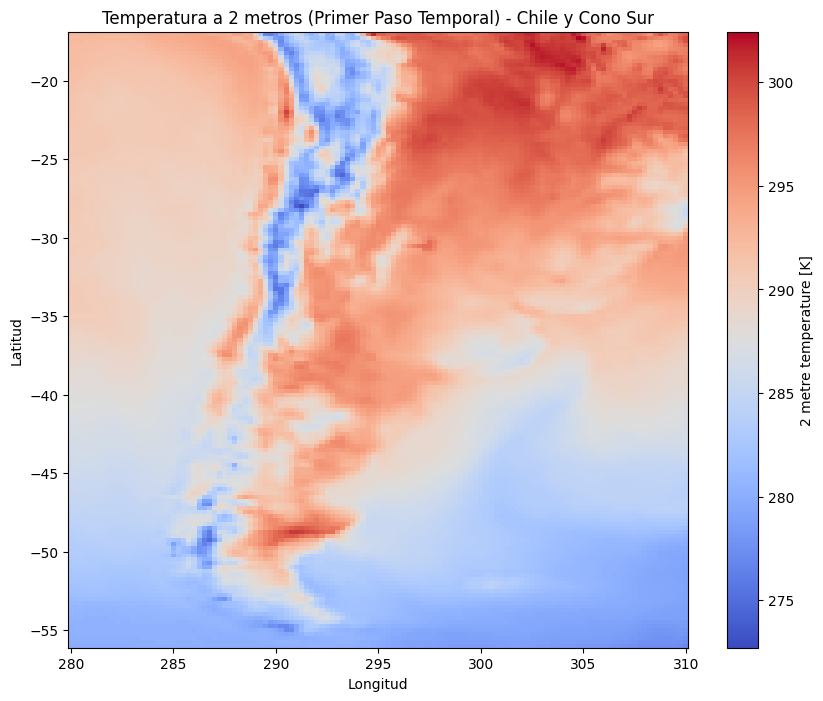

In [67]:
temp_2m = chile_ds['2m_temperature'].isel(time=0)
plt.figure(figsize=(10, 8))
temp_2m.plot(cmap="coolwarm", add_colorbar=True)
plt.title("Temperatura a 2 metros (Primer Paso Temporal) - Chile y Cono Sur")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()

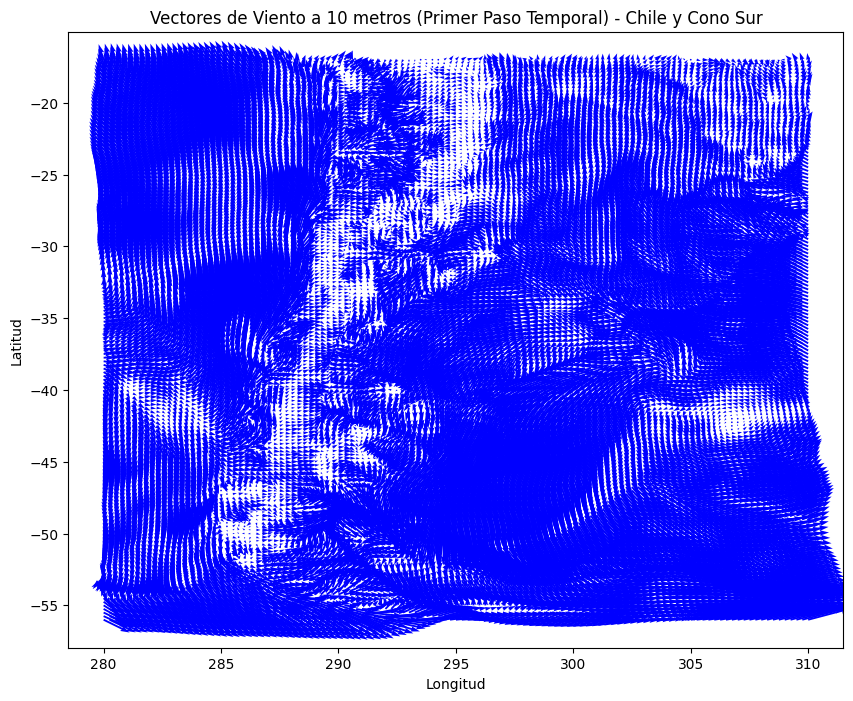

In [68]:
u_wind = chile_ds['10m_u_component_of_wind'].isel(time=0)
v_wind = chile_ds['10m_v_component_of_wind'].isel(time=0)
lon, lat = np.meshgrid(chile_ds['longitude'], chile_ds['latitude'])
plt.figure(figsize=(10, 8))
plt.quiver(lon, lat, u_wind, v_wind, scale=200, color='blue')
plt.title("Vectores de Viento a 10 metros (Primer Paso Temporal) - Chile y Cono Sur")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()


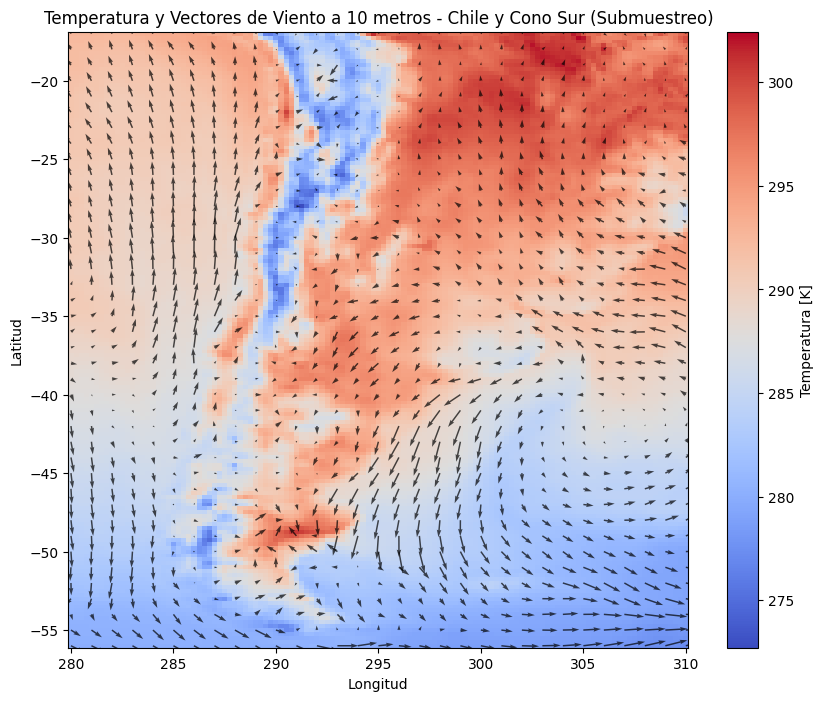

In [70]:
temp_2m = chile_ds['2m_temperature'].isel(time=0)
u_wind = chile_ds['10m_u_component_of_wind'].isel(time=0)
v_wind = chile_ds['10m_v_component_of_wind'].isel(time=0)

lon, lat = np.meshgrid(chile_ds['longitude'], chile_ds['latitude'])

step = 4
lon_subset = lon[::step, ::step]
lat_subset = lat[::step, ::step]
u_wind_subset = u_wind[::step, ::step]
v_wind_subset = v_wind[::step, ::step]

plt.figure(figsize=(10, 8))

plt.pcolormesh(lon, lat, temp_2m, cmap="coolwarm", shading="auto")
plt.colorbar(label="Temperatura [K]")
plt.quiver(lon_subset, lat_subset, u_wind_subset, v_wind_subset, scale=300, color='black', alpha=0.7)
plt.title("Temperatura y Vectores de Viento a 10 metros - Chile y Cono Sur (Submuestreo)")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()

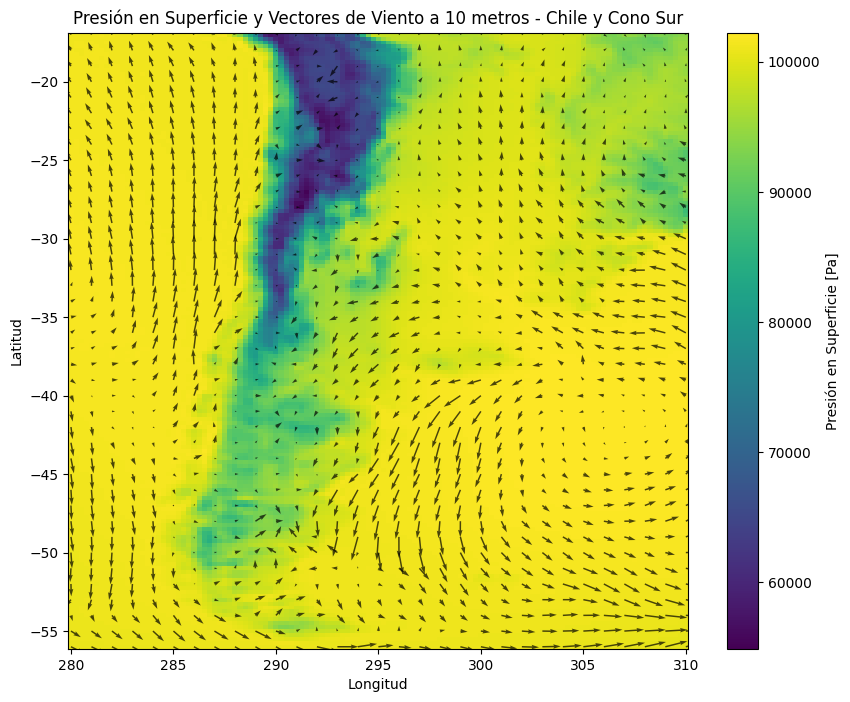

In [71]:
surface_pressure = chile_ds['surface_pressure'].isel(time=0)
u_wind = chile_ds['10m_u_component_of_wind'].isel(time=0)
v_wind = chile_ds['10m_v_component_of_wind'].isel(time=0)
lon, lat = np.meshgrid(chile_ds['longitude'], chile_ds['latitude'])
step = 4
lon_subset = lon[::step, ::step]
lat_subset = lat[::step, ::step]
u_wind_subset = u_wind[::step, ::step]
v_wind_subset = v_wind[::step, ::step]

plt.figure(figsize=(10, 8))
plt.pcolormesh(lon, lat, surface_pressure, cmap="viridis", shading="auto")
plt.colorbar(label="Presión en Superficie [Pa]")
plt.quiver(lon_subset, lat_subset, u_wind_subset, v_wind_subset, scale=300, color='black', alpha=0.7)
plt.title("Presión en Superficie y Vectores de Viento a 10 metros - Chile y Cono Sur")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()

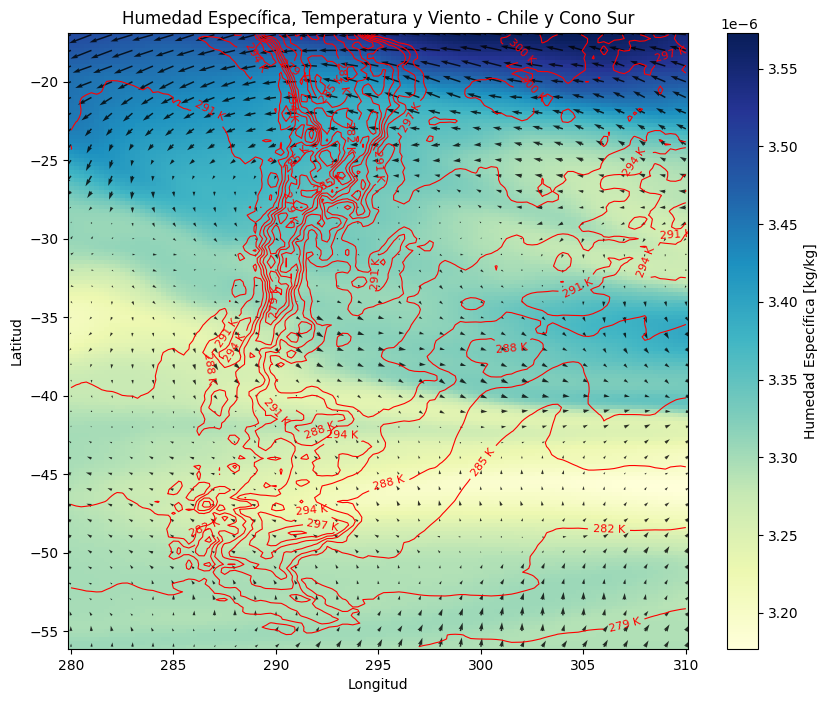

In [80]:
temp_2m = chile_ds['2m_temperature'].isel(time=0)
specific_humidity = chile_ds['specific_humidity'].isel(time=0, level=0)  # Humedad específica en el mismo nivel
u_wind = chile_ds['u_component_of_wind'].isel(time=0, level=0)
v_wind = chile_ds['v_component_of_wind'].isel(time=0, level=0)
lon, lat = np.meshgrid(chile_ds['longitude'], chile_ds['latitude'])

step = 4
lon_subset = lon[::step, ::step]
lat_subset = lat[::step, ::step]
u_wind_subset = u_wind[::step, ::step]
v_wind_subset = v_wind[::step, ::step]

plt.figure(figsize=(10, 8))
plt.pcolormesh(lon, lat, specific_humidity, cmap="YlGnBu", shading="auto")
plt.colorbar(label="Humedad Específica [kg/kg]")
contour = plt.contour(lon, lat, temp_2m, levels=10, colors='red', linewidths=0.8)
plt.clabel(contour, inline=True, fontsize=8, fmt="%.0f K")
plt.quiver(lon_subset, lat_subset, u_wind_subset, v_wind_subset, scale=500, color='black', alpha=0.8)
plt.title("Humedad Específica, Temperatura y Viento - Chile y Cono Sur")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()

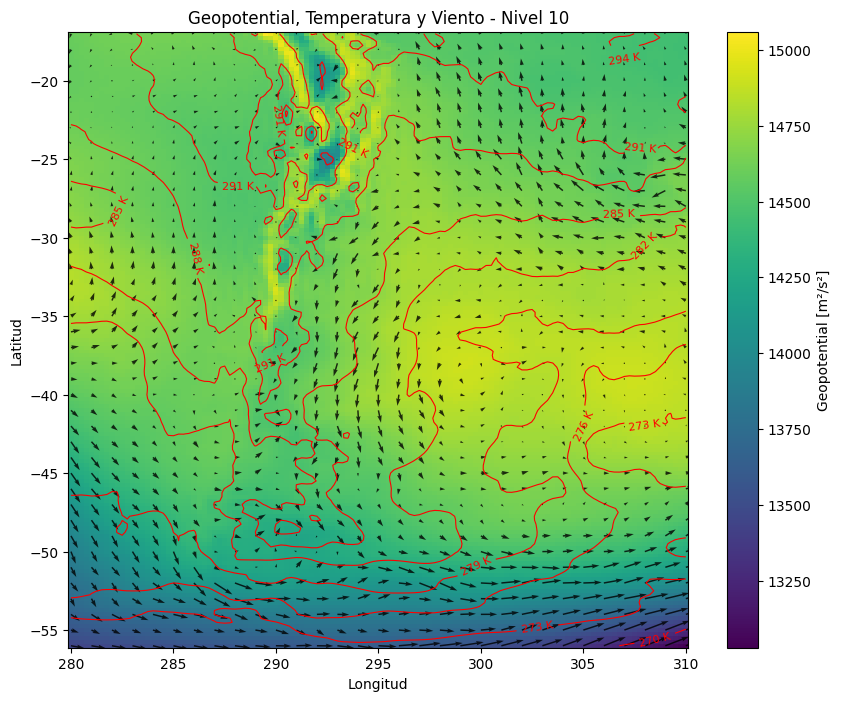

In [102]:
geopotential = chile_ds['geopotential'].isel(time=0, level=10)  # Geopotential en nivel 10
temperature = chile_ds['temperature'].isel(time=0, level=10)
specific_humidity = chile_ds['specific_humidity'].isel(time=0, level=10)
u_wind = chile_ds['u_component_of_wind'].isel(time=0, level=10)
v_wind = chile_ds['v_component_of_wind'].isel(time=0, level=10)

lon, lat = np.meshgrid(chile_ds['longitude'], chile_ds['latitude'])

step = 4
lon_subset = lon[::step, ::step]
lat_subset = lat[::step, ::step]
u_wind_subset = u_wind[::step, ::step]
v_wind_subset = v_wind[::step, ::step]

plt.figure(figsize=(10, 8))
plt.pcolormesh(lon, lat, geopotential, cmap="viridis", shading="auto")
plt.colorbar(label="Geopotential [m²/s²]")
contour = plt.contour(lon, lat, temperature, levels=10, colors='red', linewidths=0.8)
plt.clabel(contour, inline=True, fontsize=8, fmt="%.0f K")
plt.quiver(lon_subset, lat_subset, u_wind_subset, v_wind_subset, scale=500, color='black', alpha=0.8)
plt.title("Geopotential, Temperatura y Viento - Nivel 10")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()


In [12]:
variables = ['u_component_of_wind', 'v_component_of_wind', 
             'temperature', 'specific_humidity', 'geopotential']
subset_selected_ch = chile_ds[variables].isel(level=10)
print(subset_selected_ch)


<xarray.Dataset> Size: 35GB
Dimensions:              (time: 92044, latitude: 157, longitude: 121)
Coordinates:
  * latitude             (latitude) float32 628B -17.0 -17.25 ... -55.75 -56.0
    level                int64 8B 850
  * longitude            (longitude) float32 484B 280.0 280.2 ... 309.8 310.0
  * time                 (time) datetime64[ns] 736kB 1959-01-01 ... 2021-12-3...
Data variables:
    u_component_of_wind  (time, latitude, longitude) float32 7GB dask.array<chunksize=(1, 157, 121), meta=np.ndarray>
    v_component_of_wind  (time, latitude, longitude) float32 7GB dask.array<chunksize=(1, 157, 121), meta=np.ndarray>
    temperature          (time, latitude, longitude) float32 7GB dask.array<chunksize=(1, 157, 121), meta=np.ndarray>
    specific_humidity    (time, latitude, longitude) float32 7GB dask.array<chunksize=(1, 157, 121), meta=np.ndarray>
    geopotential         (time, latitude, longitude) float32 7GB dask.array<chunksize=(1, 157, 121), meta=np.ndarray>


In [13]:
subset_selected = subset_selected_ch.sel(time=slice("2010-01-01", "2010-01-31"))
print(subset_selected)

<xarray.Dataset> Size: 47MB
Dimensions:              (time: 124, latitude: 157, longitude: 121)
Coordinates:
  * latitude             (latitude) float32 628B -17.0 -17.25 ... -55.75 -56.0
    level                int64 8B 850
  * longitude            (longitude) float32 484B 280.0 280.2 ... 309.8 310.0
  * time                 (time) datetime64[ns] 992B 2010-01-01 ... 2010-01-31...
Data variables:
    u_component_of_wind  (time, latitude, longitude) float32 9MB dask.array<chunksize=(1, 157, 121), meta=np.ndarray>
    v_component_of_wind  (time, latitude, longitude) float32 9MB dask.array<chunksize=(1, 157, 121), meta=np.ndarray>
    temperature          (time, latitude, longitude) float32 9MB dask.array<chunksize=(1, 157, 121), meta=np.ndarray>
    specific_humidity    (time, latitude, longitude) float32 9MB dask.array<chunksize=(1, 157, 121), meta=np.ndarray>
    geopotential         (time, latitude, longitude) float32 9MB dask.array<chunksize=(1, 157, 121), meta=np.ndarray>


In [42]:
print(f"Subset dimensions: {subset.dims}")
print(f"Timestamps in subset: {subset.sizes['time']}")
print(f"Latitude size: {subset.sizes['latitude']}, Longitude size: {subset.sizes['longitude']}")


Subset dimensions: FrozenMappingWarningOnValuesAccess({'time': 5, 'latitude': 50, 'longitude': 50, 'level': 13})
Timestamps in subset: 5
Latitude size: 50, Longitude size: 50


In [15]:
subset_selected = subset_selected.chunk({'time': 10, 'latitude': 50, 'longitude': 50})

In [17]:
from dask.diagnostics import ProgressBar

with ProgressBar():
    subset_selected.to_zarr("dataset/chile_2010_january.zarr", consolidated=True)

[########################################] | 100% Completed | 23m 57s


In [3]:
subset_selected = xr.open_zarr("dataset/chile_2010_january.zarr")
print(subset_selected)

<xarray.Dataset> Size: 47MB
Dimensions:              (time: 124, latitude: 157, longitude: 121)
Coordinates:
  * latitude             (latitude) float32 628B -17.0 -17.25 ... -55.75 -56.0
    level                int64 8B ...
  * longitude            (longitude) float32 484B 280.0 280.2 ... 309.8 310.0
  * time                 (time) datetime64[ns] 992B 2010-01-01 ... 2010-01-31...
Data variables:
    geopotential         (time, latitude, longitude) float32 9MB dask.array<chunksize=(10, 50, 50), meta=np.ndarray>
    specific_humidity    (time, latitude, longitude) float32 9MB dask.array<chunksize=(10, 50, 50), meta=np.ndarray>
    temperature          (time, latitude, longitude) float32 9MB dask.array<chunksize=(10, 50, 50), meta=np.ndarray>
    u_component_of_wind  (time, latitude, longitude) float32 9MB dask.array<chunksize=(10, 50, 50), meta=np.ndarray>
    v_component_of_wind  (time, latitude, longitude) float32 9MB dask.array<chunksize=(10, 50, 50), meta=np.ndarray>


In [4]:
variables = ['u_component_of_wind', 'v_component_of_wind', 'temperature', 'specific_humidity', 'geopotential']

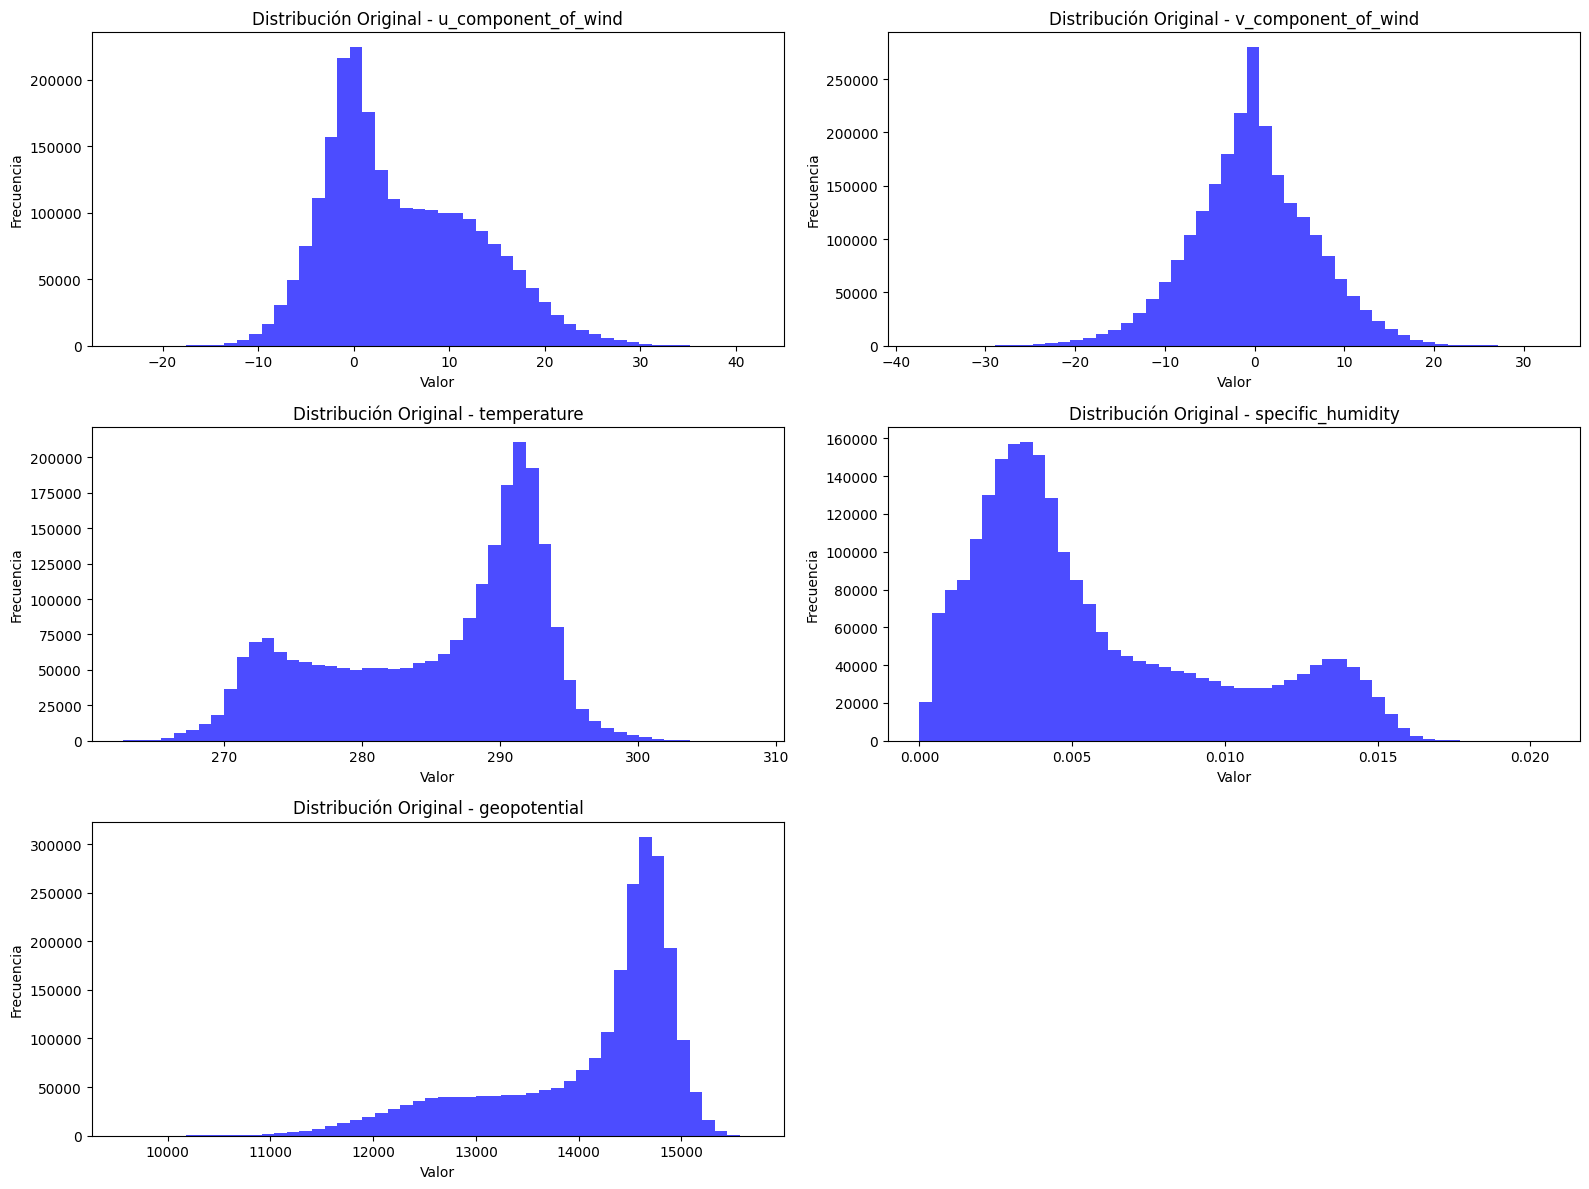

In [50]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 12)) 
axes = axes.flatten()  
for i, var in enumerate(variables):
    axes[i].hist(subset_selected[var].values.flatten(), bins=50, alpha=0.7, color="blue")
    axes[i].set_title(f'Distribución Original - {var}')
    axes[i].set_xlabel("Valor")
    axes[i].set_ylabel("Frecuencia")
for j in range(len(variables), len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

In [7]:
scaler = StandardScaler()
scaled_vars = {}
for var in variables:
    data = subset_selected[var].values.reshape(-1, 1) 
    scaled_data = scaler.fit_transform(data).reshape(subset_selected[var].shape)
    scaled_vars[var] = (['time', 'latitude', 'longitude'], scaled_data) 


In [8]:
scaled_subset = xr.Dataset(
    scaled_vars,
    coords=subset_selected.coords
)

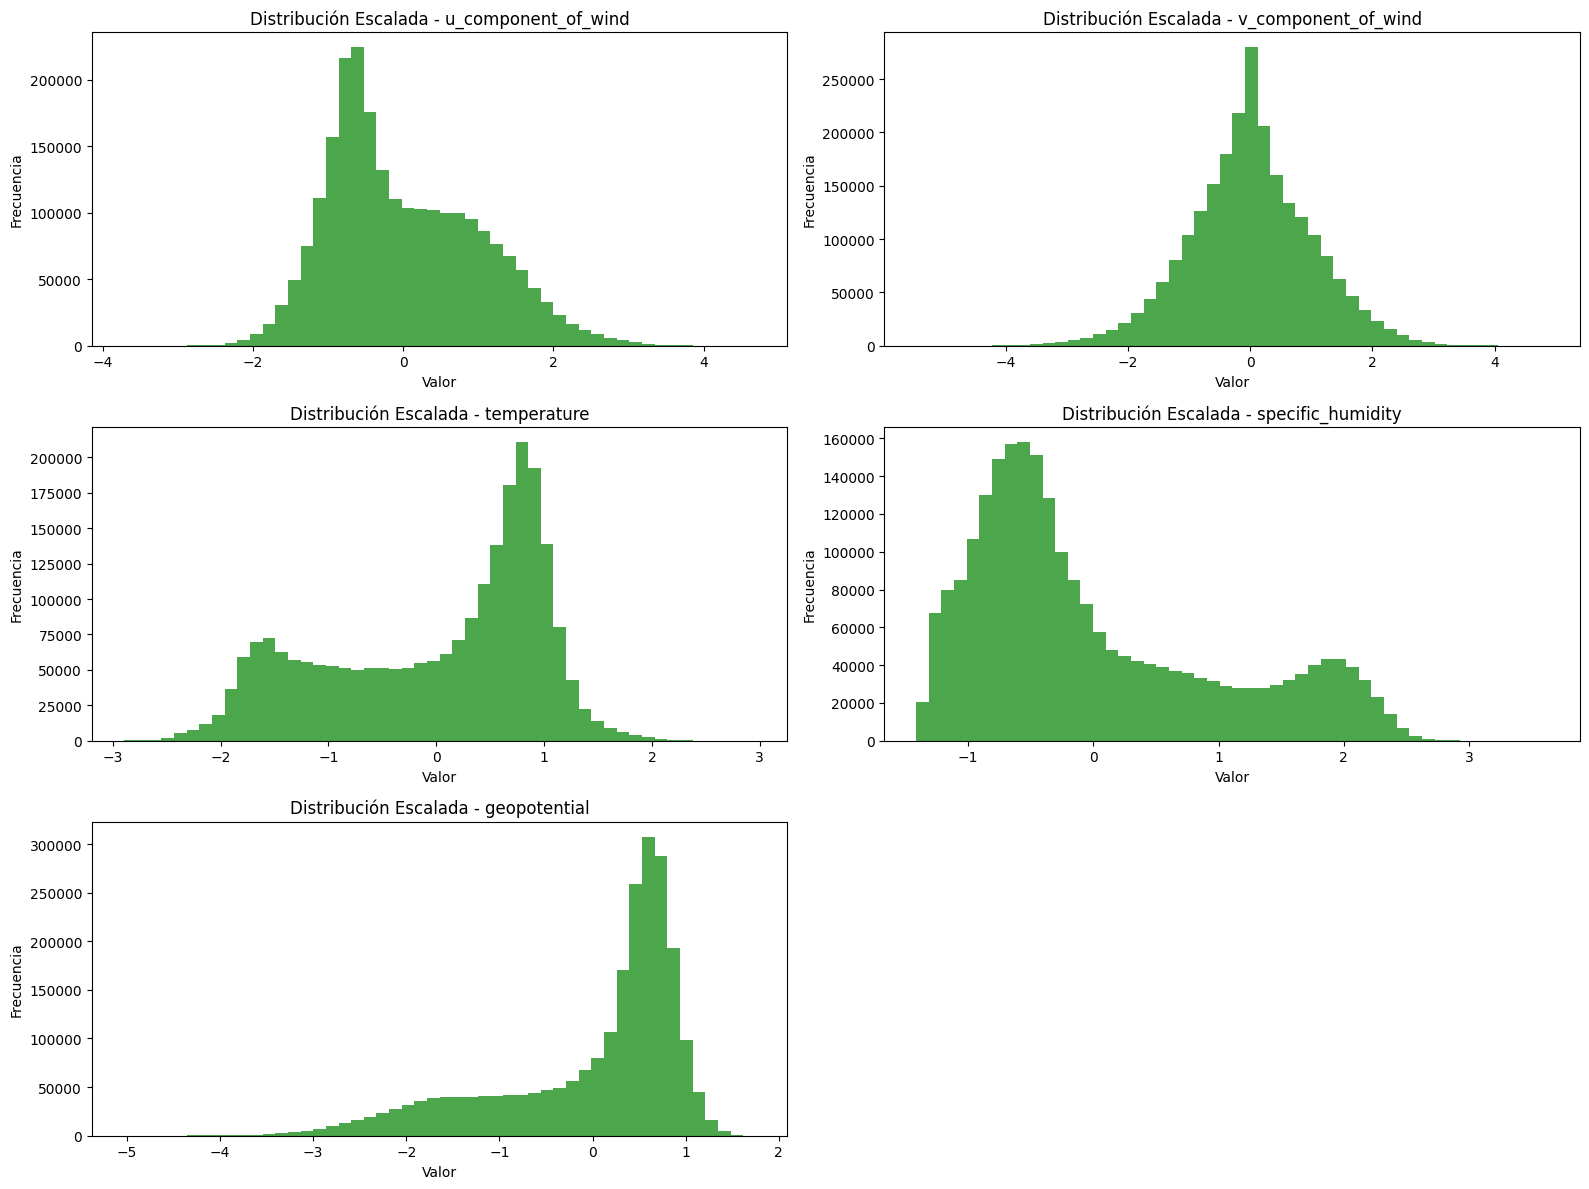

In [9]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 12))
axes = axes.flatten()
for i, var in enumerate(variables):
    axes[i].hist(scaled_subset[var].values.flatten(), bins=50, alpha=0.7, color="green")
    axes[i].set_title(f'Distribución Escalada - {var}')
    axes[i].set_xlabel("Valor")
    axes[i].set_ylabel("Frecuencia")
for j in range(len(variables), len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

In [62]:
for var in variables:
    data = scaled_subset[var].values.flatten()
    mean = np.mean(data)
    std = np.std(data)
    print(f"{var} -> Media: {mean:.5f}, Desviación estándar: {std:.5f}")

u_component_of_wind -> Media: 0.00000, Desviación estándar: 1.00000
v_component_of_wind -> Media: -0.00000, Desviación estándar: 1.00000
temperature -> Media: -0.00000, Desviación estándar: 1.00000
specific_humidity -> Media: -0.00000, Desviación estándar: 1.00000
geopotential -> Media: -0.00000, Desviación estándar: 1.00000


In [63]:
def convert_to_tensors(data):
    """
    Convierte datos de xarray a tensores PyTorch.
    """
    data_tensor = torch.tensor(data.to_array().values, dtype=torch.float32)
    data_tensor = data_tensor.permute(1, 0, 2, 3)  # (time, variables, lat, lon) -> (time, channels, height, width)
    return data_tensor

# Convertir el dataset escalado
data_tensor = convert_to_tensors(scaled_subset)

In [64]:
time_steps = data_tensor.shape[0]
train_split = int(0.7 * time_steps)
val_split = int(0.85 * time_steps)

train_tensor = data_tensor[:train_split]
val_tensor = data_tensor[train_split:val_split]
test_tensor = data_tensor[val_split:]

In [74]:
from torch.utils.data import DataLoader, TensorDataset

# Crear conjuntos con datos consecutivos
train_dataset = TensorDataset(train_tensor[:-1], train_tensor[1:])
val_dataset = TensorDataset(val_tensor[:-1], val_tensor[1:])
test_dataset = TensorDataset(test_tensor[:-1], test_tensor[1:])

# Crear DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Lotes - Entrenamiento: {len(train_loader)}, Validación: {len(val_loader)}, Prueba: {len(test_loader)}")

Lotes - Entrenamiento: 3, Validación: 1, Prueba: 1


In [75]:
import torch.nn as nn

class PINNWithCNN(nn.Module):
    def __init__(self):
        super(PINNWithCNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(5, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.conv3 = nn.Conv2d(128, 5, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return x


In [72]:
def compute_gradients(output, inputs):
    """
    Calcula gradientes parciales de la salida respecto a las dimensiones espaciales y temporales.
    """
    # Asumimos que inputs tiene las dimensiones (batch_size, channels, height, width)
    grad = torch.autograd.grad(
        outputs=output.sum(),  # Sumar para obtener gradiente escalar
        inputs=inputs,
        create_graph=True,
        retain_graph=True,
    )[0]
    # Extraer gradientes para las dimensiones espaciales y temporales
    return grad[:, 2], grad[:, 3], grad[:, 4]  # Ajustar según tus inputs

def loss_pde(model, inputs, alpha=1.0, beta_momentum=1.0, beta_continuity=1.0, beta_energy=1.0, beta_moisture=1.0):
    """
    Calcula la pérdida física basada en las ecuaciones.
    """
    inputs.requires_grad_(True)  # Habilitar gradientes para las entradas
    pred = model(inputs)

    # Separar predicciones
    u_pred = pred[:, 0, :, :]
    v_pred = pred[:, 1, :, :]
    T_pred = pred[:, 2, :, :]
    q_pred = pred[:, 3, :, :]
    p_pred = pred[:, 4, :, :]

    # Calcular gradientes
    u_x, u_y, u_t = compute_gradients(u_pred, inputs)
    v_x, v_y, v_t = compute_gradients(v_pred, inputs)
    T_x, T_y, T_t = compute_gradients(T_pred, inputs)
    q_x, q_y, q_t = compute_gradients(q_pred, inputs)
    p_x, p_y, _ = compute_gradients(p_pred, inputs)

    # Definir ecuaciones físicas
    momentum_u = u_t + u_pred * u_x + v_pred * u_y + p_x
    momentum_v = v_t + u_pred * v_x + v_pred * v_y + p_y
    continuity = u_x + v_y
    energy = T_t + u_pred * T_x + v_pred * T_y
    moisture = q_t + u_pred * q_x + v_pred * q_y

    # Calcular pérdida física
    loss_physics = (
        beta_momentum * (torch.mean(momentum_u ** 2) + torch.mean(momentum_v ** 2)) +
        beta_continuity * torch.mean(continuity ** 2) +
        beta_energy * torch.mean(energy ** 2) +
        beta_moisture * torch.mean(moisture ** 2)
    )


    return alpha * loss_physics


In [68]:
from torch.optim.lr_scheduler import LambdaLR

def train_model_with_physics(
    model, train_loader, val_loader, optimizer, loss_pde_fn, compute_accuracy_fn, device, epochs=200, alpha=0.2
):
    warmup_epochs = 10
    # Inicializar listas para métricas
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []  # Corregido
    train_loss_data_history, train_loss_physics_history = [], []
    scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: lr_lambda(epoch, warmup_epochs))

    # Entrenamiento
    for epoch in range(epochs):
        model.train()
        train_loss, train_accuracy = 0.0, 0.0
        train_loss_data, train_loss_physics = 0.0, 0.0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()

            # Habilitar gradientes en las entradas
            inputs.requires_grad_(True)
            pred = model(inputs)

            # Calcular pérdidas
            loss_physics = loss_pde_fn(model, inputs)
            loss_data = torch.nn.functional.mse_loss(pred, targets)
            loss = loss_data + alpha * loss_physics

            # Backpropagación
            loss.backward()
            optimizer.step()

            # Acumular métricas
            train_loss += loss.item()
            train_loss_data += loss_data.item()
            train_loss_physics += loss_physics.item()
            train_accuracy += compute_accuracy_fn(pred, targets)

        # Promediar métricas de entrenamiento
        train_loss /= len(train_loader)
        train_loss_data /= len(train_loader)
        train_loss_physics /= len(train_loader)
        train_accuracy /= len(train_loader)
        scheduler.step()
        
        # Validación
        model.eval()
        val_loss, val_accuracy = 0.0, 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                pred = model(inputs)
                val_loss += torch.nn.functional.mse_loss(pred, targets).item()
                val_accuracy += compute_accuracy_fn(pred, targets)

        val_loss /= len(val_loader)
        val_accuracy /= len(val_loader)

        # Guardar métricas
        train_losses.append(train_loss)
        train_loss_data_history.append(train_loss_data)
        train_loss_physics_history.append(train_loss_physics)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Imprimir una sola línea por época
        print(
            f"Epoch {epoch + 1}/{epochs}, "
            f"Train Loss: {train_loss:.6f}, Train Data Loss: {train_loss_data:.6f}, "
            f"Train Physics Loss: {train_loss_physics:.6f}, Train Accuracy: {train_accuracy:.2f}%, "
            f"Validation Loss: {val_loss:.6f}, Validation Accuracy: {val_accuracy:.2f}%"
        )
    # Retornar métricas
    return {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies,
    }


In [84]:
import gc

# Liberar objetos en memoria
gc.collect()
torch.cuda.empty_cache()

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [83]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PINNWithCNN().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=5e-5)
metrics = train_model_with_physics(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_pde_fn=loss_pde,
    compute_accuracy_fn=lambda pred, target: torch.mean((pred - target) ** 2).item(),
    device=device,
    epochs=200,
    alpha=0.1
)


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
